# Quora Questions - Text Classification

In [0]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import itertools
from nltk.corpus import stopwords
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import copy
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC

In [0]:
original_train = pd.read_csv('QuoraQuestions/train.csv')
original_test = pd.read_csv('QuoraQuestions/test.csv')

In [0]:
original_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [0]:
original_test.head()

,qid,question_text
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?
2,000227734433360e1aae,What are the best made pocket knives under $20...
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario tha...
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?


## Percentages of the two classes in the data
Two sample types:
* sincere
* insincere

In [0]:
num_sincere = float(len(original_train[original_train['target'] == 0]))
num_insincere = float(len(original_train[original_train['target'] == 1]))
print num_sincere
print num_insincere
print num_sincere / (num_sincere + num_insincere)
print num_insincere / (num_sincere + num_insincere)

1225312.0
80810.0
0.938129822482
0.0618701775179


#### Comment:
Evidently, from above we have an unbalanced dataset in which our number of sincere questions grossly outnumbers the number of insincere questions.

## Let's examine the data
Specifically, we'll look at a few samples of insincere questions from our training data.

In [0]:
original_train[original_train['target'] == 1].head()['question_text'][30] # definitively insincere

'Which babies are more sweeter to their parents? Dark skin babies or light skin babies?'

In [0]:
original_train[original_train['target'] == 1].head()['question_text'][110] # on the cusp - could be considered insincere bc "blacks" is not necessarily PC

"If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?"

In [0]:
original_train[original_train['target'] == 1].head()['question_text'][114] # lascivious and this is borderline incest

'I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and I want to see his di**. What should I do?'

In [0]:
original_train[original_train['target'] == 1].head()['question_text'][115] # definitely insincere

'Which races have the smallest penis?'

In [0]:
original_train[original_train['target'] == 1].tail()['question_text'][1306093] # part 2 - incest

'How is it to have intimate relation with your cousin?'

In [0]:
original_train[original_train['target'] == 1].tail()['question_text'][1306099] # racist towards pakistani people

'Do pakis smell of curry and shit?'

In [0]:
original_train[original_train['target'] == 1].tail()['question_text'][1306094] # provocative and trying to make a statement

'Why is it when singers have lyrics about voices in their head, religious people say they hear god and anyone stating they are being targeted by voice to brain technology? Are they called delusional schizo?'

In [0]:
split_train1 = list(map(lambda x : x.lower().split(), original_train[original_train['target'] == 1]['question_text']))
split_train0 = list(map(lambda x : x.lower().split(), original_train[original_train['target'] == 0]['question_text']))

## Pie Chart - Percent of Insincere/Sincere Questions

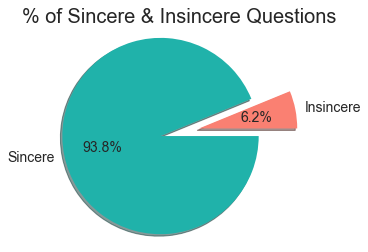

In [0]:
def question_proportion(sizes):
    # Pie-chart for sincere/insincere questions
    labels = 'Insincere', 'Sincere'
    explode = (0.4, 0)
    plt.pie(sizes, explode = explode, labels = labels, autopct='%1.1f%%', shadow=True, colors = ['salmon', 'lightseagreen'])
    plt.axis('equal')
    plt.title('% of Sincere & Insincere Questions', fontsize = 20)
    plt.show()
question_proportion(sizes = [num_insincere, num_sincere])

## Most Common First Words for Insincere/Sincere Questions

In [0]:
def common_first_words(split_train):
    most_common_words = {} # most common first words of each sincere question
    for question in split_train:
        if question[0] in most_common_words:
            most_common_words[question[0]] += 1
        else:
            most_common_words[question[0]] = 1
    sorted_by_desc = sorted(most_common_words.items(), key=lambda kv: kv[1], reverse=True)
    top7 = sorted_by_desc[0:7]
    return [top7[i][0] for i in range(7)],  [top7[i][1] for i in range(7)]

In [0]:
def plot_first_words(top7_words, top7_counts, q_type, c):
    plt.barh(top7_words, top7_counts, color = c)
    plt.title('Most Common First Words and Their Counts', fontsize = 15)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 13)
    plt.xlabel('# of Questions', fontsize = 13)
    plt.ylabel('First Word', fontsize = 14)
    if q_type == 'Sincere':
        tick_val = [100000, 200000, 300000, 400000]
        tick_lab = ['100k', '200k', '300k', '400k']
    else:
        tick_val = [10000, 20000, 30000, 40000]
        tick_lab = ['10k', '20k', '30k','40k']
    plt.xticks(tick_val,tick_lab)
    plt.legend([q_type + ' Questions'])
    sns.set_style('darkgrid')
    plt.show()

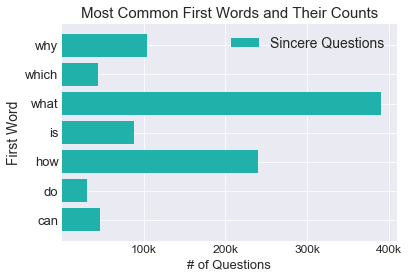

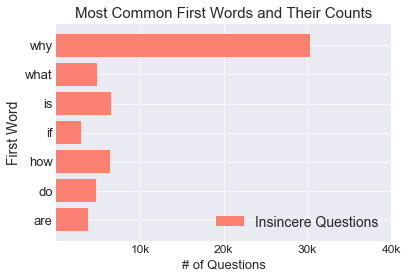

In [0]:
top7_words0, top7_counts0 = common_first_words(split_train0)
top7_words1, top7_counts1 = common_first_words(split_train1)
plot_first_words(top7_words0, top7_counts0, 'Sincere', 'lightseagreen')
plot_first_words(top7_words1, top7_counts1, 'Insincere', 'salmon')

#### Comment: 
People who ask insincere questions use significantly more "why" questions than any other question type. The "why" question assumes a statement to be true, which can be problematic in some cases. For many insincere "why" questions, the underlying assumption is inconclusive or is subjective, so the individual is more likely to be asserting an opinion rather than genuinely seeking the answer to a question.

# Distribution of Question Lengths

In [0]:
def question_lengths_distribution(split_train, q_type, c):
    question_lengths = []
    for question in split_train:
        question_lengths.append(len(question))
    sns.set_style('darkgrid')
    fig1=sns.distplot(np.array(question_lengths), color = c)
    axes = fig1.axes
    axes.set_xlim(0,35)
    fig1.set_title('Distribution of Question Lengths', fontsize = 15)
    fig1.set_xlabel('# of Words in Quesion')
    fig1.set_ylabel('Desnity')
    fig1.legend([q_type + ' Question'])
    plt.show()

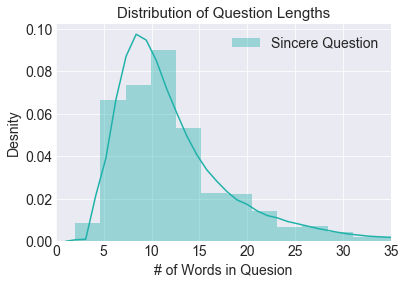

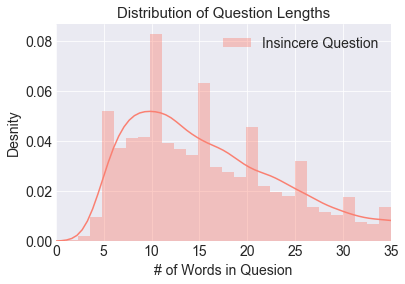

In [0]:
question_lengths_distribution(split_train0, 'Sincere', 'lightseagreen')
question_lengths_distribution(split_train1, 'Insincere', 'salmon')

#### Outliers

In [0]:
# Sincere
sincere_outlier = split_train0[489956]
print(len(sincere_outlier))
print sincere_outlier

134
['in', '"star', 'trek', '2013"', 'why', 'did', 'they', ':', '*spoilers*', '*spoilers*', '*spoilers*', '*spoilers*', '1)make', 'warping', 'look', 'quite', 'a', 'bit', 'like', 'an', 'hyperspace', 'jump', '2)what', 'in', 'the', 'world', 'were', 'those', 'bright', 'particles', 'as', 'soon', 'as', 'they', 'jumped.', '3)why', 'in', 'the', 'world', 'did', 'they', 'make', 'it', 'possible', 'for', 'two', 'entities', 'to', 'react', 'in', 'warp', 'space', 'in', 'separate', 'jumps.', '4)why', 'did', 'spock', 'get', 'emotions', 'for', 'this', 'movie.', '5)what', 'was', 'the', 'point', 'of', 'hiding', 'the', '"enterprise"', 'underwater.', '6)when', 'they', 'were', 'intercepted', 'by', 'the', 'dark', 'ship,', 'how', 'come', 'they', 'reached', 'earth', 'when', 'they', 'were', 'far', 'away', 'from', 'her.(i', "don't", 'seem', 'to', 'remember', 'the', 'scene', 'where', 'they', 'warp', 'to', 'earth).', '7)how', 'did', 'the', 'ship', 'enter', "earth's", 'atmosphere', 'when', 'it', 'wasnt', 'even', 'in

In [0]:
# Insincere
print(sorted(question_lengths_insincere)[80808])
print(sorted(question_lengths_insincere)[80809])
print(np.mean(question_lengths_insincere))

60
64
17.275015468382627


## Plot Common Word Frequencies

In [0]:
concatenated_split_train1 = list(itertools.chain.from_iterable(split_train1))
concatenated_split_train0 = list(itertools.chain.from_iterable(split_train0))
s = stopwords.words('english')
concatenated_split_train1 = list(filter(lambda x : x not in s, concatenated_split_train1))  # filter out all stop words (e.g. pronouns, articles)
concatenated_split_train0 = list(filter(lambda x : x not in s, concatenated_split_train0))

['has', 'the', 'united', 'states', 'become']

In [0]:
def common_word_freq(concatenated_split_train, q_type, c):
    top = pd.Series(concatenated_split_train).value_counts()[:40] # top 40 words 
    plt.figure(figsize=(15,15))
    plt.title("Top 40 Most Frequent Words - " + q_type + " Questions", fontsize = 20)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=15)
    plt.ylabel('Word', fontsize = 17)
    plt.xlabel('Count', fontsize = 17)
    top.plot(kind='barh', color = c)
    plt.show()

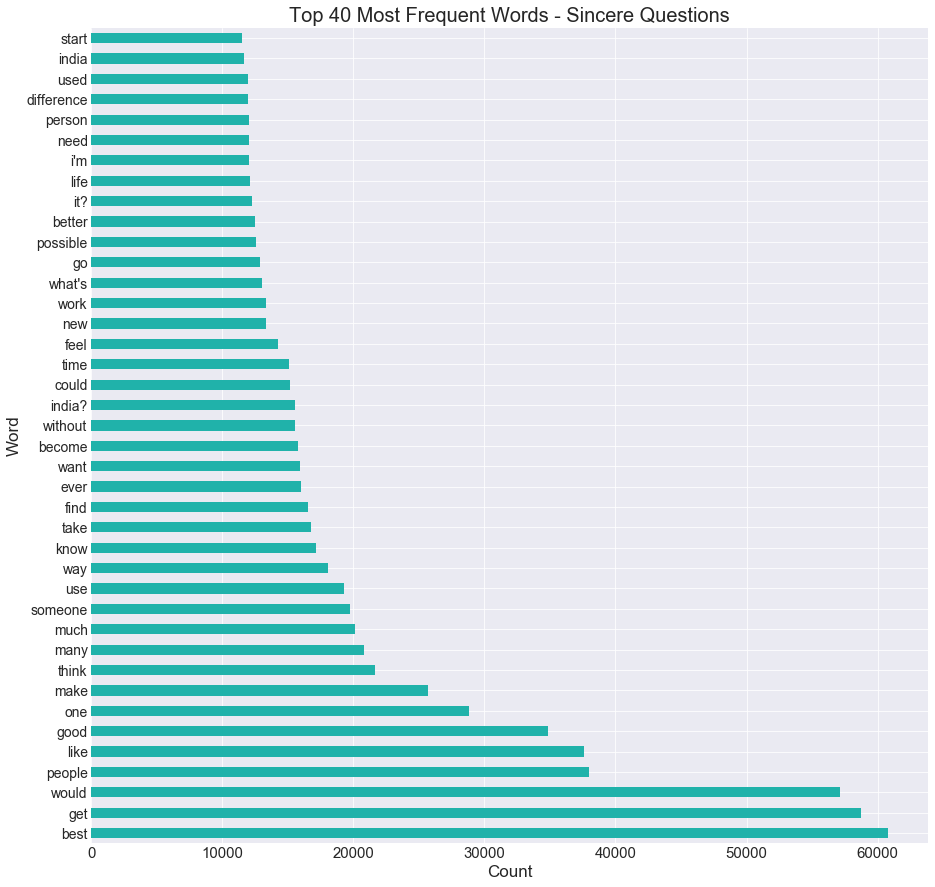

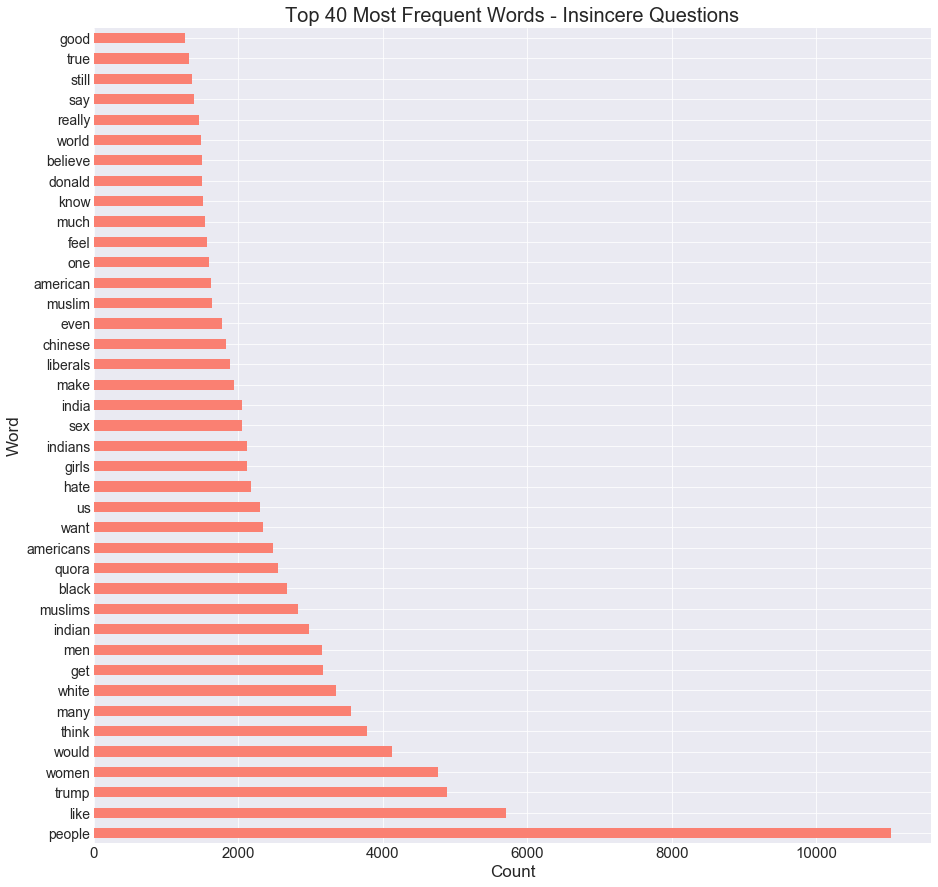

In [0]:
common_word_freq(concatenated_split_train0, 'Sincere', 'lightseagreen')
common_word_freq(concatenated_split_train1, 'Insincere', 'salmon')

## Word Cloud
Below are word clouds for sincere and insincere documents.

In [0]:
def display_wordcloud(concatenated_split_train):
    unique_string=(" ").join(concatenated_split_train)
    wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

#### Sincere

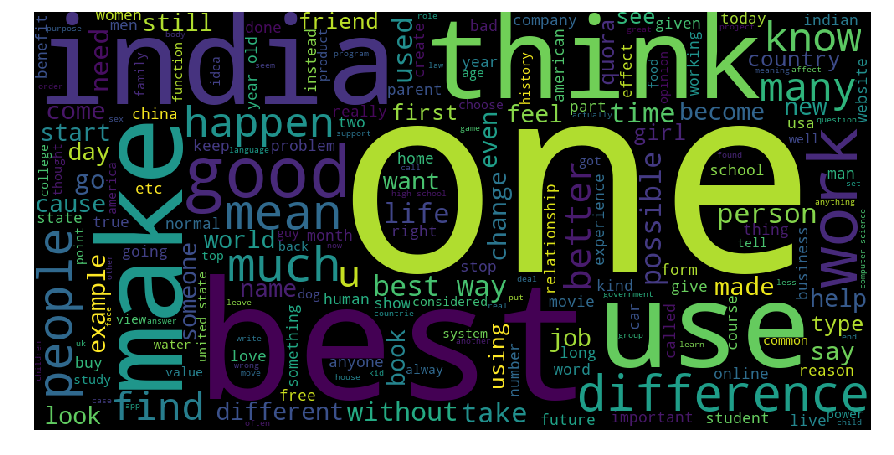

In [0]:
display_wordcloud(concatenated_split_train0)

#### Insincere 

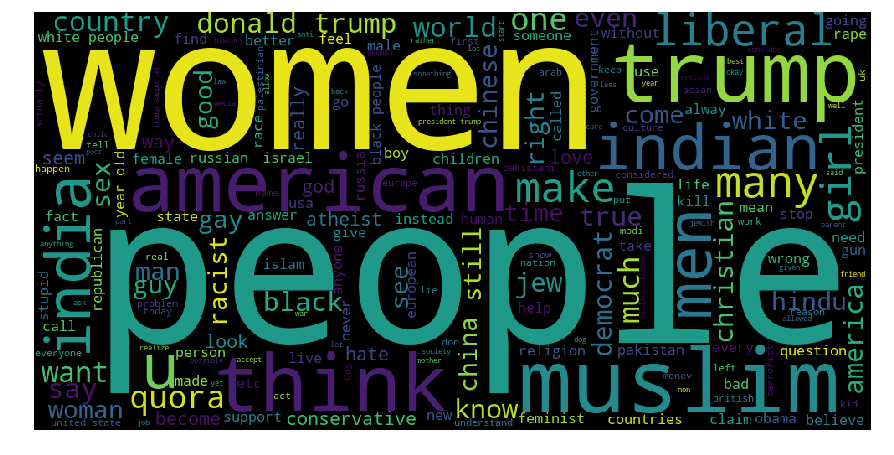

In [0]:
display_wordcloud(concatenated_split_train1)

## Bigram/Trigram Plots

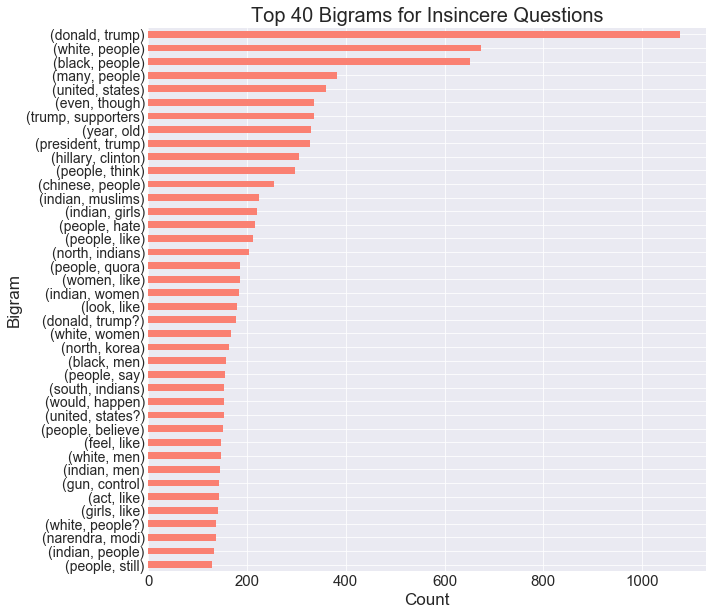

In [0]:
## Bigram plot for insincere questions
fdist_ins = {key:value for key, value in fdist_ins.items() if value >= 130 }
top_bgm = pd.Series(fdist_ins)
top_bgm = top_bgm.sort_values()
plt.figure(figsize=(10, 10))
plt.title("Top 40 Bigrams for Insincere Questions", fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=15)
plt.ylabel('Bigram', fontsize = 17)
plt.xlabel('Count', fontsize = 17)
top_bgm.plot(kind = 'barh', color = 'Salmon')
plt.show()

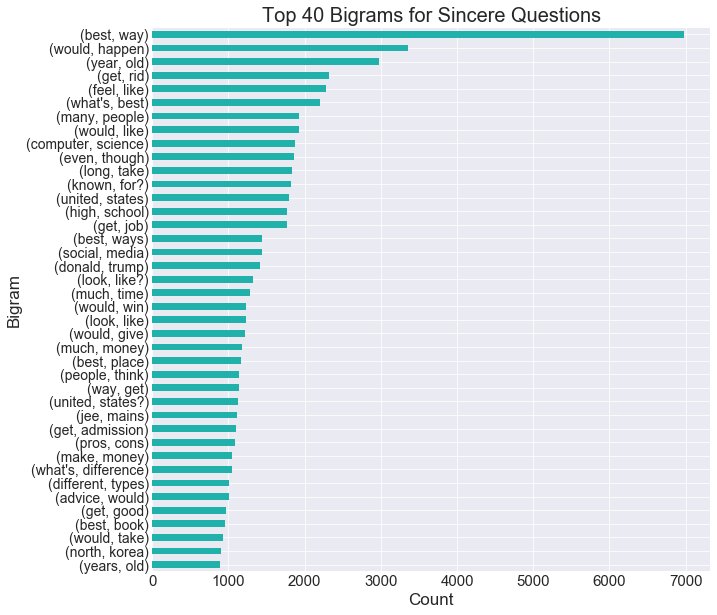

In [0]:
## Bigram plot for Sincere questions
fdist_sin = {key:value for key, value in fdist_sin.items() if value >= 888 }
top_bgm2 = pd.Series(fdist_sin)
top_bgm2 = top_bgm2.sort_values()
plt.figure(figsize=(10, 10))
plt.title("Top 40 Bigrams for Sincere Questions", fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=15)
plt.ylabel('Bigram', fontsize = 17)
plt.xlabel('Count', fontsize = 17)
top_bgm2.plot(kind = 'barh', color = 'lightseagreen')
plt.show()

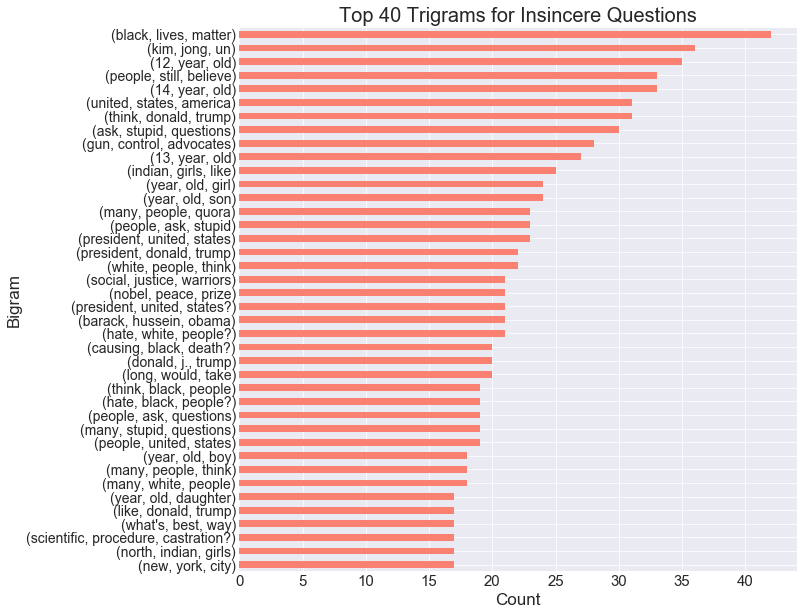

In [0]:
## Trigram plot for Insincere questions
fdist2_ins = {key:value for key, value in fdist2_ins.items() if value >= 17 }
top_tgm = pd.Series(fdist2_ins)
top_tgm = top_tgm.sort_values()
plt.figure(figsize=(10, 10))
plt.title("Top 40 Trigrams for Insincere Questions", fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=15)
plt.ylabel('Bigram', fontsize = 17)
plt.xlabel('Count', fontsize = 17)
top_tgm.plot(kind = 'barh', color = 'salmon')
plt.show()

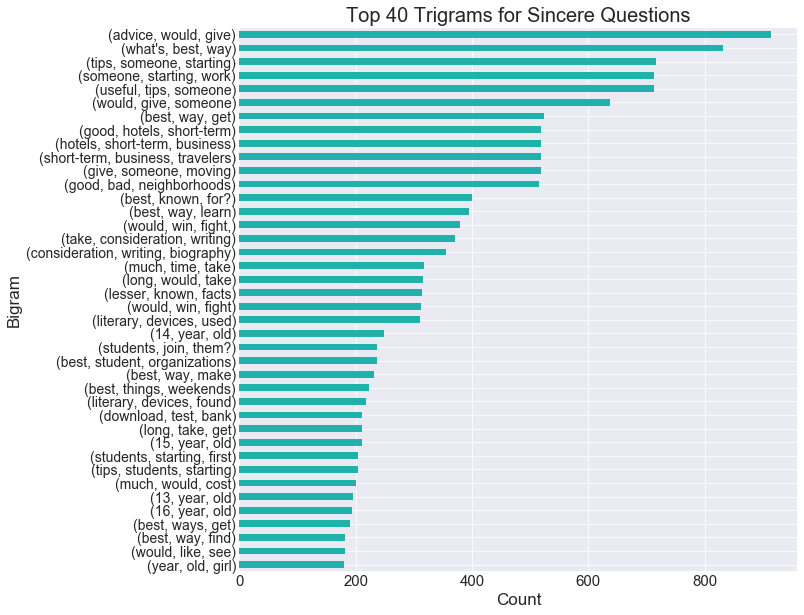

In [0]:
## Trigram plot for Sincere questions
fdist2_sin = {key:value for key, value in fdist2_sin.items() if value >= 180 }
top_tgm2 = pd.Series(fdist2_sin)
top_tgm2 = top_tgm2.sort_values()
top_tgm2 = top_tgm2.drop([('student', 'organizations', 'join')])
plt.figure(figsize=(10, 10))
plt.title("Top 40 Trigrams for Sincere Questions", fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=15)
plt.ylabel('Bigram', fontsize = 17)
plt.xlabel('Count', fontsize = 17)
top_tgm2.plot(kind = 'barh', color = 'lightseagreen')
plt.show()

# Create Features for Training/Testing Data
Our input values will be constructed as follows:
* Features = columns
* Samples = rows

Let's concatenate the questions from the training data and testing data so that we can create the features based on the entire dataset. If we were to do this for the training and testing datasets individually, this would cause errors when we try to predict values from our testing dataset due to different number of dimensions in the number of columns in train compared to test data.

In [0]:
def get_data(x_train, x_test, y_train):
    x = copy.deepcopy(x_train)
    z = copy.deepcopy(x_test)
    y = copy.deepcopy(y_train)
    x = x.append(z)
    x = x.reset_index(drop = True)
    x = np.array(list(map(lambda a: a.lower(), x)))# convert all the values to lowercase so that the stopwords can be filtered better
    return x, y, z

In [0]:
X, Y, Z = get_data(original_train['question_text'], original_test['question_text'], original_train['target'])

In [0]:
X.shape # total samples (includes training and testing samples)

(1362492L,)

In [0]:
print len(Z) # length of test dataset
print float(len(Z))/len(X) # proportion of the entire dataset that is testing data

56370
0.0413727199866


In [0]:
 # proportion of the dataset that is training data
valid_size = len(X) - len(Z)
print float(valid_size)/len(X)

0.958627280013


#### Now, create features through word counts

In [0]:
# gets word counts of all unique words in the dataset - Bag of Words Representation (order doesn't matter)
count_vect = CountVectorizer(stop_words = 'english') # remove stop_words (e.g. the, a, in, pronouns, etc.)
X_train_counts = count_vect.fit_transform(X)

In [0]:
print X[5]
print X_train_counts[5]
print X_train_counts.shape

is gaza slowly becoming auschwitz, dachau or treblinka for palestinians?
  (0, 21690)	1
  (0, 49324)	1
  (0, 74503)	1
  (0, 131520)	1
  (0, 163923)	1
  (0, 180661)	1
(1362492, 199138)


#### TF-IDF (term frequency- inverse document frequency)
* f = frequency of the word in the sample question
* t = total number of documents
* n = number of documents the word is present in
* TF-IDF value = f * log(t/n)

For each question, the TF-IDF vector has TF-IDF value for each word among all the documents. This means there will be many 0s in the entries of the sample since several words will not be present in a given question. 

In [0]:
# most of the tf-idf values in this dataset are less than 1, but it's possible for them to exceed 1
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape # the shape here is the (num_samples, num_features) where num_features == unique words

(1362492, 199138)

In [0]:
X[5] # initial format of question

'is gaza slowly becoming auschwitz, dachau or treblinka for palestinians?'

In [0]:
samp = X_train_tfidf[5].todense() # 1 sample - the question converted into a vector of counts and then a vector of word frequencies
print samp
print samp[samp != 0.0][0,:]
print samp.shape

[[0. 0. 0. ... 0. 0. 0.]]
[[0.41783408 0.47241485 0.37168327 0.3099009  0.32646986 0.51134069]]
(1L, 199138L)


# Cross Validation
Let's evaluate the performance of our model here based on this resampling procedure. Then we will use all of our available data to train on for our finalized model. For our finalized model, since we are using all available training data, the scores from the cross validation will give us an idea of how our finalized model will perform in general. 

Keep in mind:
* recall = TP / TP + FN
* precision = TP / TP + FP

#### Model Selection:
- Initially started with a MultinomialNB clasifier
- As our base model, we set all the target values equal to the majority class
- This resulted in high accuracy, but zero precision and recall as expected
- We then used the all of the observed target values for which we got a high but lower accuracy score, low precision, and low recall 
- We then realized that a BernoulliNB classifier would be more suitible for our data since the bernoulli distribution describes our data better
- From here, we thought we'd explore a support vector machine since it is a generally high performing classifier
- We used a linear SVC, which initially didn't perform that well (low recall, high precision); however, we took into account  the low recall due to the imbalanced nature of the dataset
- So we decided to add a high penalty for misclassifying the minority class through class weights
- This meant that we would have a high class weight (penalty) for the minority class and the opposite for the complement class
- #### https://chrisalbon.com/machine_learning/support_vector_machines/imbalanced_classes_in_svm/

In [0]:
scorer = ['accuracy', 'precision', 'recall', 'f1']
algorithm = LinearSVC(class_weight = {0: .2, 1: .8}) # add a high penalty for missclassifying the minority class
num_splits = 10
cv_results_actual = cross_validate(algorithm, X_train_tfidf[:len(X) - len(Z)], Y, scoring = ('accuracy', 'precision', 'recall', 'f1'), cv = num_splits, return_train_score = True)

In [0]:
# This function shows how well the procedure performs on average
def show_avg_scores(cv_results, n_splits):
    print "Accuracy: " + str(np.mean(cv_results['test_accuracy']))
    print "Precision: " + str(np.mean(cv_results['test_precision']))
    print "Recall: " + str(np.mean(cv_results['test_recall']))
    print "Harmonic Mean: " + str(np.mean(cv_results['test_f1']))

In [0]:
# this function shows how much we expect the performance of the model to vary
def show_std_scores(cv_results, n_splits):
    print "Accuracy: " + str(np.std(cv_results['test_accuracy']))
    print "Precision: " + str(np.std(cv_results['test_precision']))
    print "Recall: " + str(np.std(cv_results['test_recall']))
    print "Harmonic Mean: " + str(np.std(cv_results['test_f1']))

In [0]:
show_avg_scores(cv_results_actual, num_splits)

Accuracy: 0.9430987302286304
Precision: 0.5309245198764927
Recall: 0.6896299962875883
Harmonic Mean: 0.5999561603750352


### Comment:
The precision is okay, but could be better. The model is identifying too many questions as insincere incorrectly.

The recall is fair, but could be better. The model is missing questions that are insincere. 

In [0]:
show_std_scores(cv_results_actual, num_splits)

Accuracy: 0.0005137235290098857
Precision: 0.003275430055434313
Recall: 0.003104769124604941
Harmonic Mean: 0.0030149982971205583


### Comment:
Above you can see that the spread is relatively low (close to zero), so we conclude that our model performance will be fairly consistent.

## Let's try something...
How can we compare the model performance to a simpler method in which we search for common words 

In [0]:
top_insincere_words = pd.Series(concatenated_split_train1).value_counts()

In [0]:
#searches = ['trump', 'women', 'white', ' indian', ' muslims', 'americans', 'indians', 'sex']
searches = list(top_insincere_words.index[:100])
insincere_questions = []
sincere_questions = []
for sublist in split_train1:
    if set(sublist) & set(searches):
        insincere_questions.append(sublist)
for sublist in split_train0:
    if set(sublist) & set(searches):
        sincere_questions.append(sublist)
print "Insincere:" + str(len(insincere_questions)/num_insincere)
print "Sincere:" + str(len(sincere_questions)/num_sincere)

Insincere:0.818029946789
Sincere:0.490993314356


Ideally we want the insincere score above to be as close to 1 as possible, and we want the sincere score to be as close to zero as possible
* this means high recall
* and high precision 

From the above results, we can see that this very simplistic model performs significantly worse than our trained model. 

# Finalized Model 
#### Linear SVC

In [0]:
def model(alg, x, y, validation_size):
    classifier = alg.fit(x[:validation_size], y)
    predicted = classifier.predict(x[validation_size:])
    return predicted

In [0]:
algorithm = LinearSVC(class_weight = {0: .2, 1: .8}) # add a high penalty for missclassifying the minority class
y_pred = model(algorithm, X_train_tfidf, Y, valid_size)

In [0]:
# percent of final testing data which is insincere - this percentage closely mirrors that of the training sample for insincere questions
float(len(y_pred[y_pred != 0]))/ len(y_pred)

0.0797232570516232

In [0]:
len(y_pred)

56370

In [0]:
def display_samples(i, x, valid_size, y):
    print x[valid_size + i]
    print y[i]

In [0]:
# these are the indices of the testing dataset, Z, that were predicted to be insincere
insincere_predicted_indices = list(np.where(y_pred != 0)[0])

In [0]:
# display insincere samples
a = insincere_predicted_indices[10]
print a
display_samples(a, X, valid_size, y_pred)

104
if an indian muslim had to choose between his religion or country what will he/she choose and why?
1


# Future Work

#### To improve performance:

In [0]:
# TODO: implement word embeddings (this takes into account context)

In [0]:
# TODO: create features with n-grams (instead of using words as feature columns, use phrases with n words)

#### To explore and visualize the data:

In [0]:
# TODO: group questions into themes: e.g. racism, sexism, homophobic, sexuality, religious intolerance, 
# prejudice towards immigrants, unproductive political criticism
# Visualize this data
# Show percentages of each type

# what we define these themes to be: 
    # look for all insincere questions that include a word denoting an ethnic group (e.g. blacks, jews, muslims)
    # look for all insincere questions that include a word denoting a sex(e.g. woman, women, man, men)
    # look for all insincere questions that include a word denoting a sexual preference(e.g gay, homo, fag, trans, transgender, LGBTQ)
    # look for all insincere questions that include a word denoting a religious group*( e.g. religious people, jews, muslims, christians)
    # look for all insincere questions that include a word denoting a sexual term (sexy, gay, kiss, etc.)
    # look for all insincere questions that include a word denoting immigrants (immigrants, fabs, fresh off the boat)
    # look for all insincere questions that include words(s) or phrases(s) denoting a politcal topic (liberals, libs, libtards, democrats, republicans, conservatives, nazis, neo-nazis, president's name, politcal commentators, etc.)

In [0]:
# larger question for discussion section: although people make such discriminatory remarks, should we censor the online public?
# what are the implications of online censorship? 
    # Argument against censorship: people have dark, deep thoughts that may be contentious but perhaps they truly believe 
    # those thoughts and are genuinely curious. The online public could offer a medium to express and discuss those thoughts. 
    # One key advantage of online forums is the option to be anonymous, which makes one more open to share dark ideas. 